In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.stattools import periodogram, adfuller, acf, pacf
from math import isnan

In [4]:
def insertMissingDays(df):
    start = datetime(2000, 3, 1)
    end = datetime(2017, 9, 1)
    step = timedelta(days=1)

    while start <= end:
        if start.weekday() < 5: # 5 - Saturday, 6 - Sunday
            if not (start in df.index):
                df.loc[start] = df[:start].iloc[-1]
                df.loc[start, 'Holiday'] = 1
                df.sort_index(inplace = True)
            else:
                df.loc[start, 'Holiday'] = 0
        start += step
    
    return df

In [19]:
def acquireData(path, assetType, asset, samplingFrequency, replicateForHolidays = False):
    filepath = path + '/' + assetType + '/' + asset + '/' + samplingFrequency + '/' + asset + '.CSV'
    
    df = pd.read_csv(filepath, delimiter=';', decimal=',',
                     parse_dates=['Date'], dayfirst=True, index_col='Date')
    df = df.sort_index() #csv entries begin from most recent to older dates
    
    if replicateForHolidays:
        df.loc[:,'Holiday'] = 0
        df = insertMissingDays(df)
    
    df['Close_r'] = np.log(df.Close/df.Close.shift(1))
    
    return df.drop(df.index[0])

In [6]:
def plot_returnSeries(df, asset, initialPlotDate = '', finalPlotDate = ''):
    initialPlotDate = initialPlotDate if initialPlotDate else df.index[0]
    finalPlotDate = finalPlotDate if finalPlotDate else df.index[-1]
    title = asset + ' (' + initialPlotDate + ')' if initialPlotDate == finalPlotDate else asset + ' (' + initialPlotDate + ' to ' + finalPlotDate + ')'

    fig, ax = plt.subplots(figsize=(10,10), nrows = 2, ncols = 1, sharex = True)

    plot_data = df[initialPlotDate:finalPlotDate]
    plt.xlabel('Date')
    ax[0].set_title(title)
    ax[0].set_ylabel('Price')
    ax[0].plot(plot_data['Close'])
    ax[0].grid()

    ax[1].set_ylabel('Returns')
    ax[1].plot(plot_data['Close_r'])
    ax[1].grid()

In [7]:
def plot_periodogram(df, column, initialLag = 0, numberOfLags = 30, yLog = False):
    if isnan(df[column].iloc[0]):
        df = df.drop(df.index[0])
    pgram = periodogram(df[column])
    length = len(pgram) if len(pgram) < numberOfLags else numberOfLags + 1

    fig, ax = plt.subplots(figsize=(10,10), nrows = 1, ncols = 1, sharex = True)
    plot_data = pgram[initialLag:length]
    plt.xlabel('Lags')
    ax.set_title('Periodogram')
    if yLog:
        plt.yscale('log')
    ax.stem(range(initialLag, length), plot_data)

In [8]:
def plot_seasonalDecompose(df, asset, column, initialPlotDate = '', finalPlotDate = '', frequency = 1):
    if isnan(df[column].iloc[0]):
        df = df.drop(df.index[0])
    initialPlotDate = initialPlotDate if initialPlotDate else df.index[0]
    finalPlotDate = finalPlotDate if finalPlotDate else df.index[-1]
    title = asset + column + ' (' + initialPlotDate + ')' if initialPlotDate == finalPlotDate else asset + ' (' + initialPlotDate + ' to ' + finalPlotDate + ')'
    initialIndex = np.where(df.index == df[initialPlotDate:finalPlotDate].index[0])[0][0]
    finalIndex = np.where(df.index == df[initialPlotDate:finalPlotDate].index[-1])[0][0] + 1

    result = seasonal_decompose(df[column].values, model='additive', freq=frequency, two_sided=False)

    fig, ax = plt.subplots(figsize=(10,15), nrows = 4, ncols = 1)

    plot_data = df[initialPlotDate:finalPlotDate]
    plt.xlabel('Date')
    ax[0].set_title(title)
    ax[0].plot(df[initialPlotDate:finalPlotDate].index,plot_data[column],'b-')
    #ax[0].plot(df[initialPlotDate:finalPlotDate].index,plot_data['Open'],'r:')
    #ax[0].plot(df[initialPlotDate:finalPlotDate].index,plot_data['High'],'g:')
    #ax[0].plot(df[initialPlotDate:finalPlotDate].index,plot_data['Low'],'g:')
    ax[0].grid()

    ax[1].set_title('trend')
    ax[1].plot(df[initialPlotDate:finalPlotDate].index,result.trend[initialIndex:finalIndex])
    ax[1].grid()

    ax[2].set_title('seasonal')
    ax[2].plot(df[initialPlotDate:finalPlotDate].index,result.seasonal[initialIndex:finalIndex])
    ax[2].grid()

    ax[3].set_title('resid')
    ax[3].plot(df[initialPlotDate:finalPlotDate].index,result.resid[initialIndex:finalIndex])
    ax[3].grid()

In [15]:
def test_stationarity(ts, window, initialPlotDate='', finalPlotDate=''):
    if isnan(ts.iloc[0]):
        ts = ts.drop(ts.index[0])
    initialPlotDate = initialPlotDate if initialPlotDate else ts.index[0]
    finalPlotDate = finalPlotDate if finalPlotDate else ts.index[-1]

    #Determing rolling statistics
    rolmean = ts.rolling(window=window,center=False).mean()
    rolstd = ts.rolling(window=window,center=False).std()

    fig, ax = plt.subplots(figsize=(15,10), nrows = 1, ncols = 1, sharex = True)
    #Plot rolling statistics:
    ax.plot(ts[initialPlotDate:finalPlotDate], color='blue',label='Original')
    ax.plot(rolmean[initialPlotDate:finalPlotDate], color='red', label='Rolling Mean')
    ax.plot(rolstd[initialPlotDate:finalPlotDate], color='black', label = 'Rolling Std')
    ax.legend(loc='best')
    ax.set_title('Rolling Mean & Standard Deviation')

    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

In [17]:
def plot_acfAndPacf(df, lags):
    lag_acf = acf(df, nlags=lags)
    lag_pacf = pacf(df, nlags=lags, method='ols')

    fig, ax = plt.subplots(figsize=(10,5), nrows = 1, ncols = 2)

    #Plot ACF:
    ax[0].stem(lag_acf)
    ax[0].axhline(y=0,linestyle='--',color='gray')
    ax[0].axhline(y=-7.96/np.sqrt(len(df)),linestyle='--',color='gray')
    ax[0].axhline(y=7.96/np.sqrt(len(df)),linestyle='--',color='gray')
    ax[0].set_title('Autocorrelation Function')

    #Plot PACF:
    ax[1].stem(lag_pacf)
    ax[1].axhline(y=0,linestyle='--',color='gray')
    ax[1].axhline(y=-7.96/np.sqrt(len(df)),linestyle='--',color='gray')
    ax[1].axhline(y=7.96/np.sqrt(len(df)),linestyle='--',color='gray')
    ax[1].set_title('Partial Autocorrelation Function')
    plt.tight_layout()

In [20]:
dataPath = '/home/danilofrp/projeto_final/data'
assetType = 'stocks'
asset = 'PETR4'
frequency = 'diario'

df = acquireData(dataPath, assetType, asset, frequency, replicateForHolidays = True)

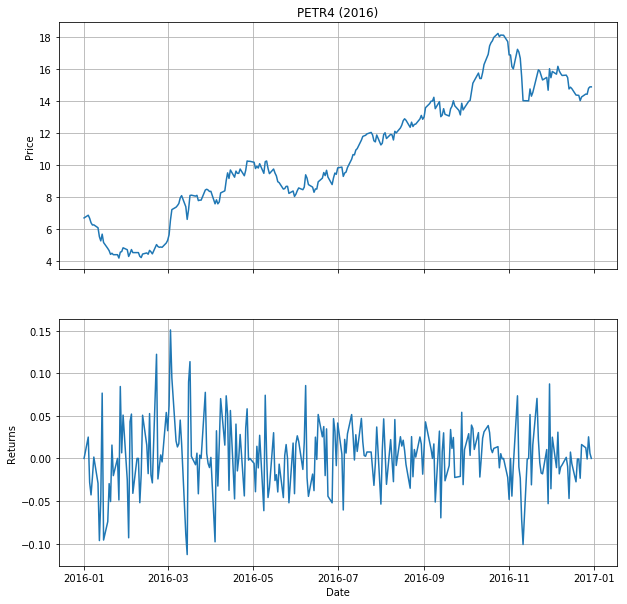

In [11]:
%matplotlib inline
plot_returnSeries(df, asset, initialPlotDate='2016', finalPlotDate='2016')

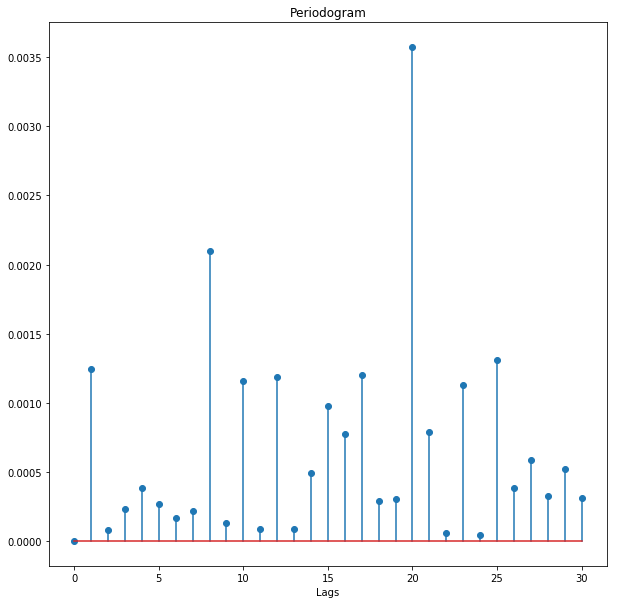

In [12]:
%matplotlib inline
plot_periodogram(df, 'Close_r', initialLag = 0, numberOfLags = 30, yLog = False)

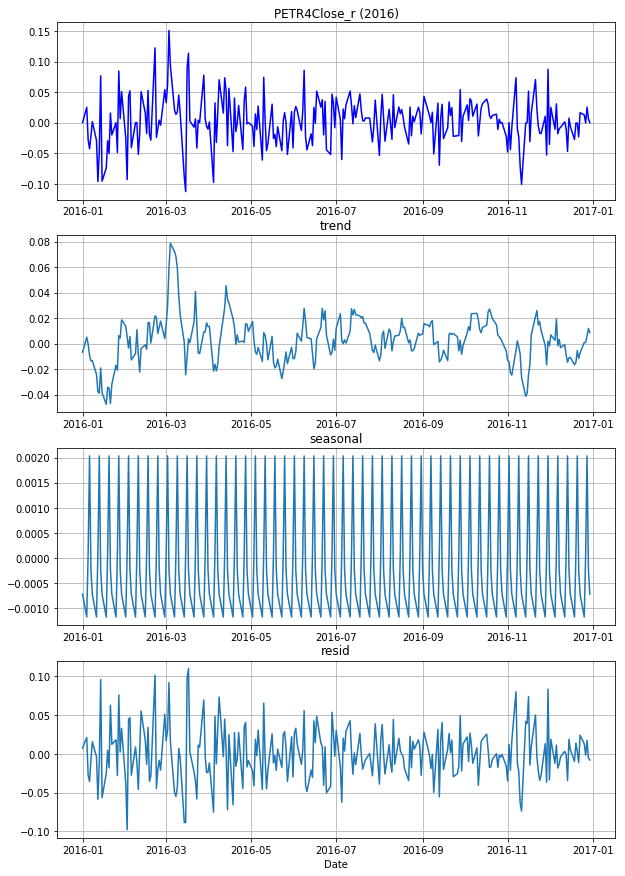

In [13]:
%matplotlib inline
#%matplotlib tk
plot_seasonalDecompose(df, asset, 'Close_r', initialPlotDate='2016', finalPlotDate='2016', frequency=5)

Results of Dickey-Fuller Test:
Test Statistic                  -39.483246
p-value                           0.000000
#Lags Used                        2.000000
Number of Observations Used    4389.000000
Critical Value (5%)              -2.862199
Critical Value (1%)              -3.431841
Critical Value (10%)             -2.567121
dtype: float64


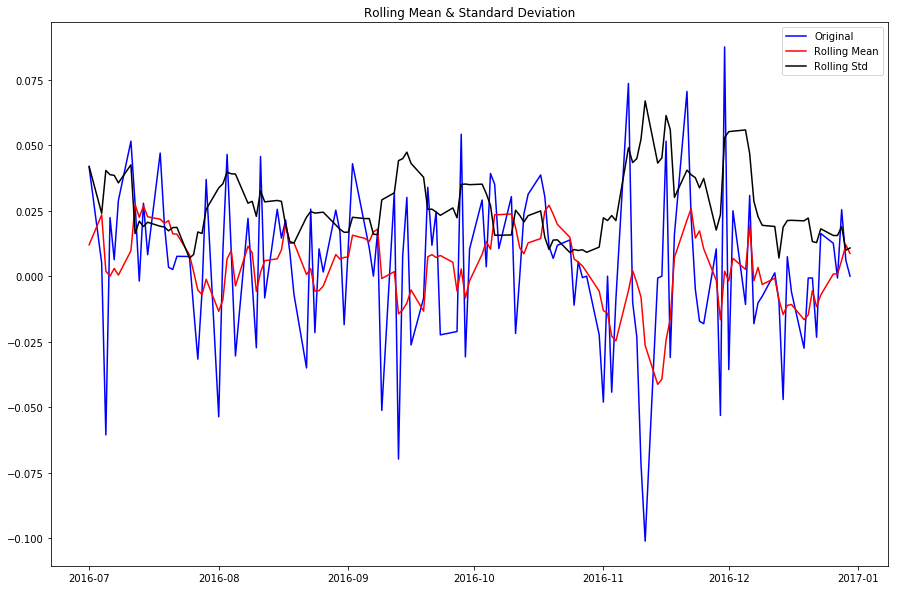

In [30]:
%matplotlib inline
test_stationarity(df['Close_r'][:'2016'], window=5, initialPlotDate='2016-07', finalPlotDate='2016-12')

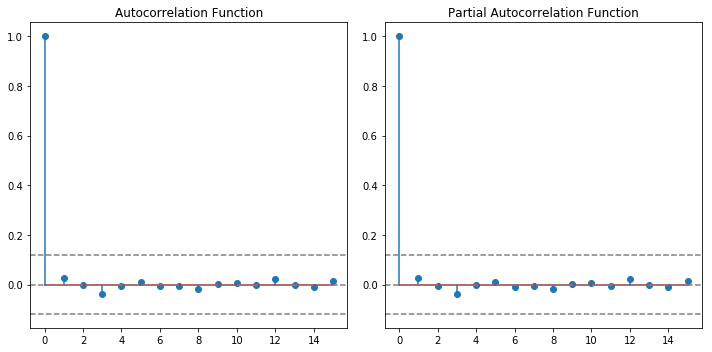

In [21]:
plot_acfAndPacf(df['Close_r'], 15)

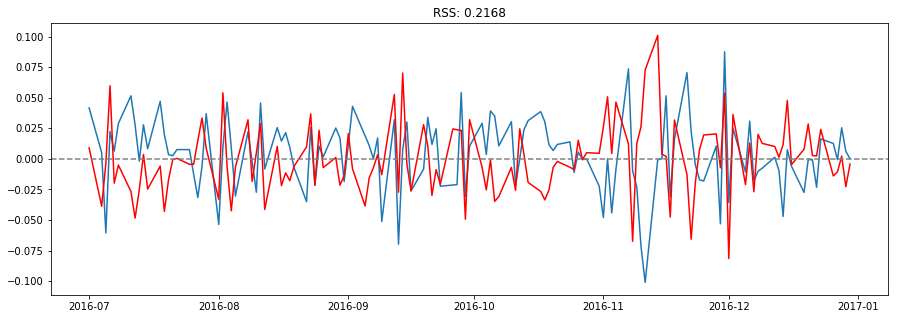

In [31]:
model = ARIMA(df['Close_r'][:'2016'], order=(2, 1, 1))
results_ARIMA = model.fit(disp=-1)

fig, ax = plt.subplots(figsize=(15,5), nrows = 1, ncols = 1, sharex = True)
ax.plot(df['Close_r']['2016-07':'2016-12'])
ax.plot(results_ARIMA.fittedvalues['2016-07':'2016-12'], color='red')
ax.set_title('RSS: %.4f'% sum((results_ARIMA.fittedvalues['2016-07':'2016-12']-df['Close_r']['2016-07':'2016-12'])**2))
ax.axhline(y=0,linestyle='--',color='gray')